In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Extracting MFCC features...


100%|██████████| 3000/3000 [00:13<00:00, 224.61it/s]


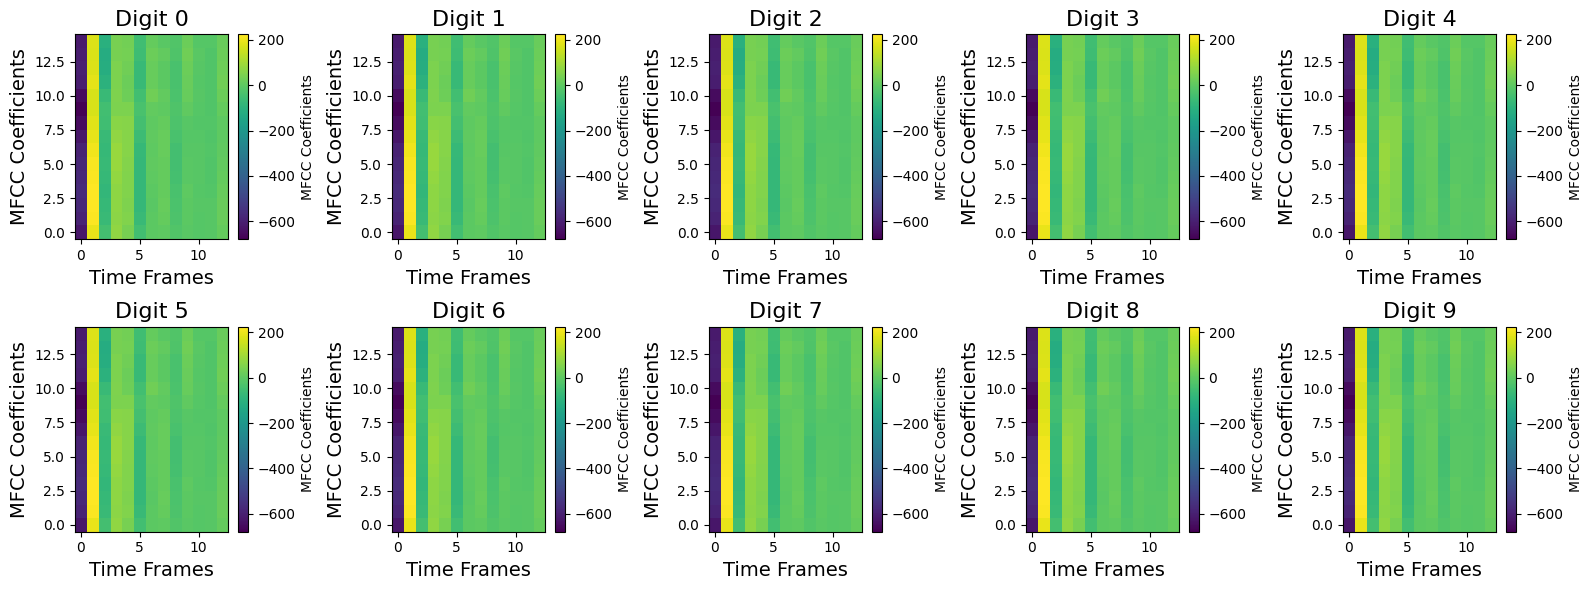

In [3]:
class FSDDProcessor:
    def __init__(self, data_path, n_mfcc=13, sr=8000):
        self.data_path = data_path
        self.n_mfcc = n_mfcc
        self.sr = sr
    
    def extract_mfcc(self, audio_path):
        y, sr = librosa.load(audio_path, sr=self.sr)
        
        mfcc = librosa.feature.mfcc(
            y=y,
            sr=sr,
            n_mfcc=self.n_mfcc,
            n_fft = 512
        )
        return mfcc
    
    def process_dataset(self):
        features = []
        labels = []
        filenames = []
        
        for root, _, files in os.walk(self.data_path):
            for file in tqdm(files):
                if file.endswith('.wav'):
                    digit = int(file.split('_')[0])
                    
                    audio_path = os.path.join(root, file)
                    mfcc = self.extract_mfcc(audio_path)
                    
                    features.append(mfcc)
                    labels.append(digit)
                    filenames.append(file)
        
        return features, np.array(labels), filenames

    def visualize_mfcc_patterns(self, features, labels, n_samples=5):
        
        mfcc_x = []

        for audio_file in os.listdir(self.data_path):
            file_path = os.path.join(self.data_path, audio_file)
            y, sr = librosa.load(file_path)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfcc_x.append(mfcc.T)   
        
        X = np.vstack(mfcc_x)

        plt.figure(figsize=(16, 6))

        for digit in range(10):
            plt.subplot(2, 5, digit + 1) 
            avg_mfcc = mfcc_x[0]
            plt.imshow(avg_mfcc, cmap='viridis', origin='lower', aspect='auto')
            plt.colorbar(label='MFCC Coefficients')
            plt.title(f'Digit {digit}', fontsize=16)
            plt.xlabel('Time Frames', fontsize=14)
            plt.ylabel('MFCC Coefficients', fontsize=14)

        plt.tight_layout()
        plt.show()
        

def extract_mfcc(data_path):

    processor = FSDDProcessor(data_path)
    
    print("\nExtracting MFCC features...")
    features, labels, filenames = processor.process_dataset()
    
    processor.visualize_mfcc_patterns(features, labels)
    
    return features, labels

features, labels = extract_mfcc("../../data/external/fsdd/")


In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

print(f"Training data size: {len(X_train)} samples")
print(f"Test data size: {len(X_test)} samples")


Training data size: 2400 samples
Test data size: 600 samples


In [8]:
def fit(features, labels, n_components=4, n_mix=2):
    models = {}
    
    for digit in range(10):
        digit_features = [mfcc.T for mfcc, label in zip(features, labels) if label == digit]
        length = [len(f) for f in digit_features]
        X_digit = np.vstack(digit_features)
        length_digit = np.vstack(length)
        model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=100)
        
        model.fit(X_digit,lengths=length_digit)
        
        models[digit] = model
    
    return models

def predict_with_hmm_models(models, features):
    predictions = []
    
    for mfcc in features:
        X = mfcc.T
        
        log_likelihoods = []
        for _, model in models.items():
            log_likelihoods.append(model.score(X))
        
        predicted_digit = np.argmax(log_likelihoods)
        predictions.append(predicted_digit)
    
    return predictions

def evaluate_model(models, X_test, y_test):
    predictions = predict_with_hmm_models(models, X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy*100

print("Training HMM models:")
models = fit(X_train, y_train)

accuracy = evaluate_model(models, X_test, y_test)

print(f"Model accuracy: {accuracy:.2f}")



Training HMM models:
Model accuracy: 90.83



Extracting MFCC features...


100%|██████████| 30/30 [00:00<00:00, 162.05it/s]


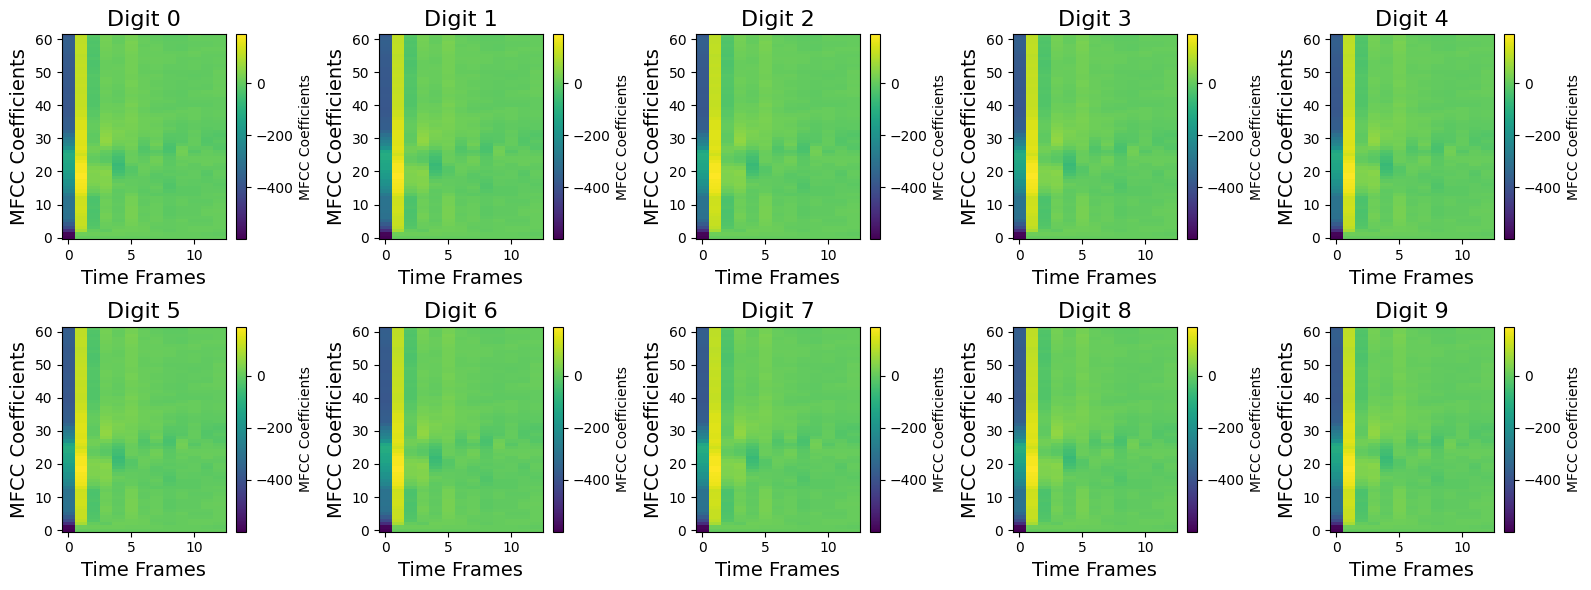

In [4]:
features_self, labels_self = extract_mfcc("../../data/external/digits/")

In [9]:
accuracy_self = evaluate_model(models, features_self, labels_self)

print(f"Model accuracy: {accuracy_self:.2f}")

Model accuracy: 36.67
